In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [14]:
import matplotlib.pyplot as plt
import time
import numpy as np

In [26]:
from logger import Logger

ImportError: cannot import name 'Logger'

In [25]:
logger

<module 'logger' from 'C:\\Users\\iamph\\Miniconda3\\envs\\tensorflow\\lib\\site-packages\\logger\\__init__.py'>

In [2]:
# Device Configuration
device = torch.device('cpu')

In [3]:
# Hyperparameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

In [6]:
# QMNIST Dataset
train_dataset = torchvision.datasets.QMNIST(root='../../data/',
                                           train = True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.QMNIST(root='../../data/',
                                       train = True,
                                       transform=transforms.ToTensor(),
                                       download=True)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = batch_size,
                                          shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False)

In [8]:
display_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20)

In [10]:
batch = next(iter(display_loader))
images, labels = batch

print('types:', type(images), type(labels))
print('shapes:', images.shape, labels.shape)

types: <class 'torch.Tensor'> <class 'torch.Tensor'>
shapes: torch.Size([20, 1, 28, 28]) torch.Size([20])


labels: tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9])


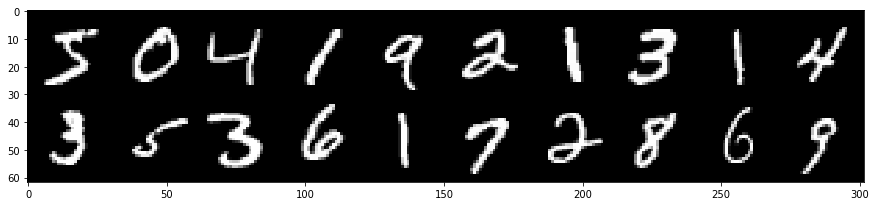

In [15]:
# Let's take a look at the dataset
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize = (15,15))
plt.imshow(np.transpose(grid, (1,2,0))) #grid.permute is also okay

print('labels:', labels)

In [36]:
#CNN (two layers)
class ConvNet(nn.Module):
    def __init__(self, input_size=784, hidden_size=500, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [54]:
model = ConvNet(num_classes).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Interim: I want to see how I can get the accuracy of the model

In [47]:
model(images).argmax(axis=1)

tensor([4, 7, 4, 3, 1, 1, 2, 3, 9, 4, 1, 5, 5, 2, 0, 5, 3, 6, 3, 6, 6, 8, 9, 8,
        0, 9, 1, 4, 0, 3, 1, 8, 4, 6, 7, 3, 8, 4, 3, 6, 8, 2, 5, 0, 9, 3, 4, 7,
        7, 1, 5, 0, 8, 9, 2, 9, 6, 1, 2, 5, 3, 2, 3, 7, 6, 9, 1, 0, 2, 8, 7, 1,
        9, 8, 5, 7, 9, 6, 8, 8, 4, 1, 0, 2, 9, 9, 8, 8, 3, 8, 5, 6, 4, 2, 5, 0,
        8, 9, 6, 5])

In [45]:
labels

tensor([4, 7, 4, 3, 1, 1, 2, 3, 9, 4, 1, 5, 5, 2, 0, 5, 3, 6, 3, 6, 6, 8, 9, 8,
        0, 9, 1, 4, 0, 3, 1, 8, 4, 6, 7, 3, 8, 4, 3, 6, 8, 2, 5, 0, 9, 3, 4, 7,
        7, 1, 5, 0, 8, 9, 2, 9, 6, 1, 2, 5, 3, 2, 3, 7, 6, 9, 1, 0, 2, 8, 7, 1,
        9, 8, 5, 7, 9, 6, 8, 8, 4, 1, 0, 2, 9, 9, 8, 8, 3, 8, 5, 6, 4, 2, 5, 0,
        8, 9, 6, 5])

In [52]:
# Test how to get model accuracy
(model(images).argmax(axis=1) == labels).sum().item()

100

In [53]:
len(train_dataset)

60000

### Back to training

In [55]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    correct = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Check accuracy progress:
        correct += (model(images).argmax(axis=1) == labels).sum().item()
        
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        
        if (i+1) % 600 == 0:
            accuracy = correct / len(train_dataset) * 100
            print('Epoch [{}/{}], Accuracy: {:.2f} %'.format(epoch+1, num_epochs, accuracy))

Epoch [1/5], Step [100/600], Loss: 0.2819
Epoch [1/5], Step [200/600], Loss: 0.0662
Epoch [1/5], Step [300/600], Loss: 0.0967
Epoch [1/5], Step [400/600], Loss: 0.0503
Epoch [1/5], Step [500/600], Loss: 0.0512
Epoch [1/5], Step [600/600], Loss: 0.0258
Epoch [1/5], Accuracy: 96.571667 %
Epoch [2/5], Step [100/600], Loss: 0.0529
Epoch [2/5], Step [200/600], Loss: 0.0091
Epoch [2/5], Step [300/600], Loss: 0.0689
Epoch [2/5], Step [400/600], Loss: 0.0180
Epoch [2/5], Step [500/600], Loss: 0.0275
Epoch [2/5], Step [600/600], Loss: 0.0296
Epoch [2/5], Accuracy: 98.803333 %
Epoch [3/5], Step [100/600], Loss: 0.0071
Epoch [3/5], Step [200/600], Loss: 0.0048
Epoch [3/5], Step [300/600], Loss: 0.0222
Epoch [3/5], Step [400/600], Loss: 0.0509
Epoch [3/5], Step [500/600], Loss: 0.0548
Epoch [3/5], Step [600/600], Loss: 0.0252
Epoch [3/5], Accuracy: 99.170000 %
Epoch [4/5], Step [100/600], Loss: 0.0499
Epoch [4/5], Step [200/600], Loss: 0.0045
Epoch [4/5], Step [300/600], Loss: 0.0591
Epoch [4/5], 

In [56]:
# Test the model
model.eval() # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch. no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 99.43333333333334 %


In [58]:
correct

59660

In [60]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

This was quite straightforward actually. Let's finish the report today and move on

In [20]:
'''
model = ConvNet().to(device)

logger = Logger('./logs')

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

data_iter = iter(data_loader)
iter_per_epoch = len(data_loader)
total_step = 50000

# Start training
for step in range(total_step):
    
    # Reset the data_iter
    if (step+1) % iter_per_epoch == 0:
        data_iter = iter(data_loader)
        
    # Fetch images and labels
    images, labels = next(data_iter)
    images, labels = images.view(image.size(0), -1).to(device), labels.to(device)
    
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward and optimise
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Compute Accuracy
    _, argmax = torch.max(outputs, 1)
    accuracy = (labels == argmax.squeeze()).float().mean()
    
    if (step+1) % 100 == 0:
        print('Step [{}/{}], Loss: {:.4f}, Acc: {:.2f}'
             .format(step+1, total_step, loss.item(), accuracy.item()))
        
    # ================================================================== #
    #                        Tensorboard Logging                         #
    # ================================================================== #
    
    # 1. Log scalar values (scalar summary)
    info = { 'loss': loss.item(), 'accuracy': accuracy.item()}
    
    for tag, value in info.items():
        logger.scalar_summary(tag, value, step+1)
        
    # 2. Log values and gradients of the parameters (histogram summary)
    for tag, value in model.named_parameters():
        tag = tag.replace('.', '/')
        logger.histo_summary(tag, value.data.cpu().numpy(). step+1)
        logger.histo_summary(tag+'/grad', value_grad.data.cpu().numpy(), step+1)
        
    # 3. Log traning images (image summary)
    info = {'images': images.view(-1, 28, 28)[:10].cpu().numpy()}
    
    for tag, images in info.items():
        logger.image_summary(tag, images, step+1)
'''

NameError: name 'Logger' is not defined